In [1]:
%load_ext autoreload
%autoreload 2

In [182]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import ipywidgets
import pandas
import pathlib
import numpy
from matplotlib import cm, pyplot

import pymc3
import arviz
import theano.tensor as tt
import xarray

import retl
import calibr8
import robotools

import model
import helper

In [3]:
DP_RUN = pathlib.Path(r"X:\CM\Pahpshmir_BL-sGFP-Cutinase-BSI\9REA8P")
DP_RESULTS = pathlib.Path("9REA8P_Results")
DP_RESULTS.mkdir(exist_ok=True)

### Load `calibr8` models

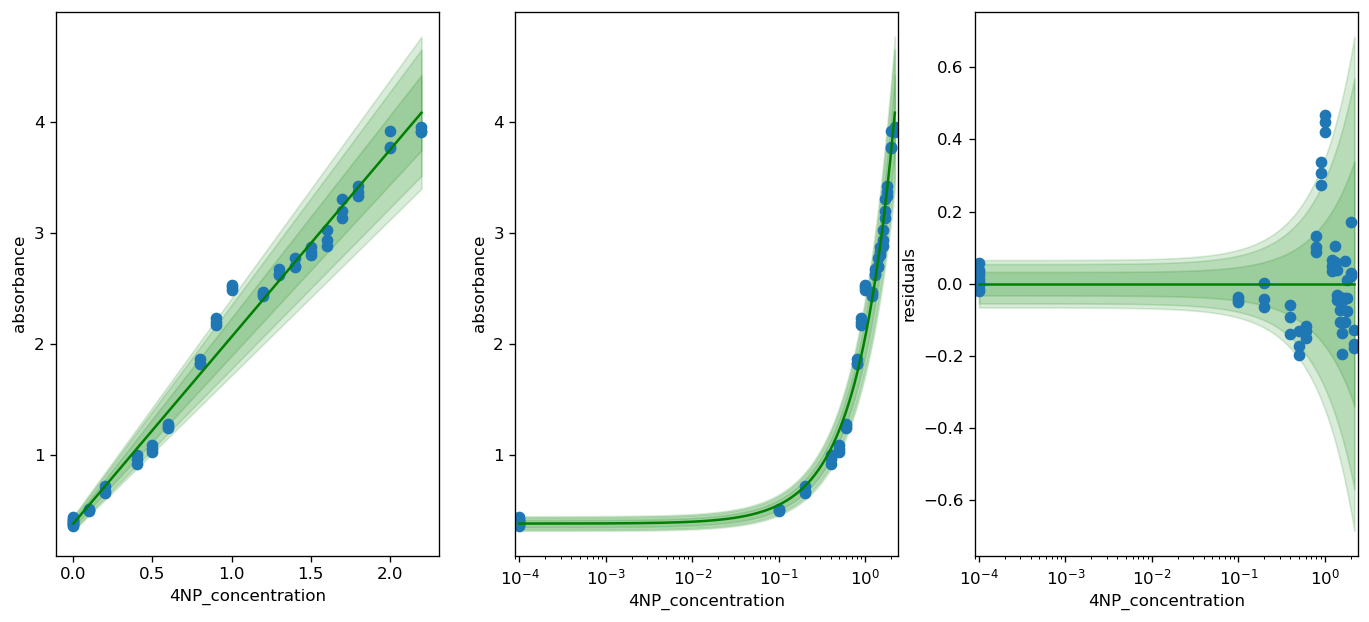

In [4]:
em_nitrophenol = model.NitrophenolAbsorbanceModel.load(pathlib.Path(DP_RESULTS, "9REA8P_em_nitrophenol.json"))
fig, axs = calibr8.plot_model(em_nitrophenol)
pyplot.show()

### Cutinase activities (standalone)
1. read cutinase kinetics
2. built multilevel linear regression model , using the anticipated cutinase concentration for well-specific $v_{max}$ priors

In [230]:
# construct a DataFrame of cutinase concentration factors in the "standards"
# the standards were located in columns [1-3] of the "samples" DWP
# they were copied into [4-6] within the "samples" DWP
# and again copied into [7-12] of the assay plate
plan = robotools.DilutionPlan(
    xmin=0.01, xmax=1,
    R=8, C=3,
    stock=1,
    mode="log",
    vmax=950,
    min_transfer=30
)

df_cut_concentration = pandas.DataFrame(index=list("ABCDEFGH"), columns=list(map(str, range(1, 13))))
df_cut_concentration.values[:, [0,1,2]] = plan.x
df_cut_concentration = helper.to_long_wells(df_cut_concentration, value_name="concentration_factor").dropna()
df_cut_concentration["concentration_factor"] = df_cut_concentration.concentration_factor.astype(float)
df_cut_concentration["fp_well"] = None
df_cut_concentration.index.name = "sample_well"
df_cut_concentration["assay_wells"] = [
    f"{rw},{rw[0]}{int(rw[1:])+3:02d},{rw[0]}{int(rw[1:])+6:02d},{rw[0]}{int(rw[1:])+9:02d}"
    for rw in df_cut_concentration.index
]
df_cut_concentration.head()

concentration_factor fp_well      assay_wells
sample_well                                               
A01                      1.000000    None  A01,A04,A07,A10
A02                      0.201053    None  A02,A05,A08,A11
A03                      0.041053    None  A03,A06,A09,A12
B01                      0.818947    None  B01,B04,B07,B10
B02                      0.165263    None  B02,B05,B08,B11

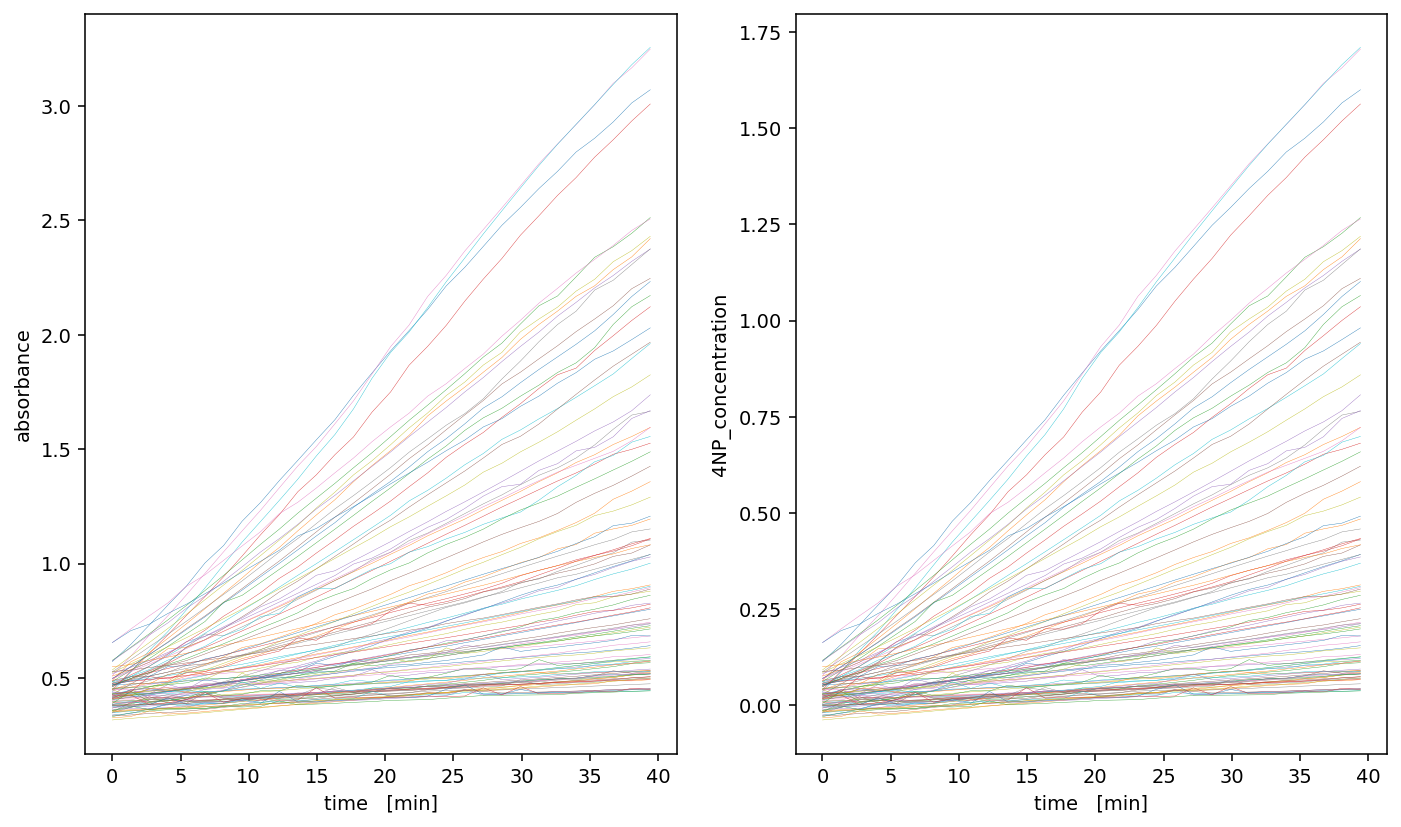

In [231]:
df_time, df_samples, t_obs, y_obs = helper.read_cutinase(DP_RUN, df_cut_concentration)

fig, (left, right) = pyplot.subplots(dpi=140, ncols=2, figsize=(12, 7))
for well in df_samples.columns:
    t = df_time[well]
    y = df_samples[well]
    left.plot(
        t,
        y,
        linewidth=0.2
    )
    right.plot(
        t,
        em_nitrophenol.predict_independent(y),
        linewidth=0.2
    )
left.set_ylabel('absorbance')
right.set_ylabel(em_nitrophenol.independent_key)
left.set_xlabel('time   [min]')
right.set_xlabel('time   [min]')
pyplot.show()

216 dimensions


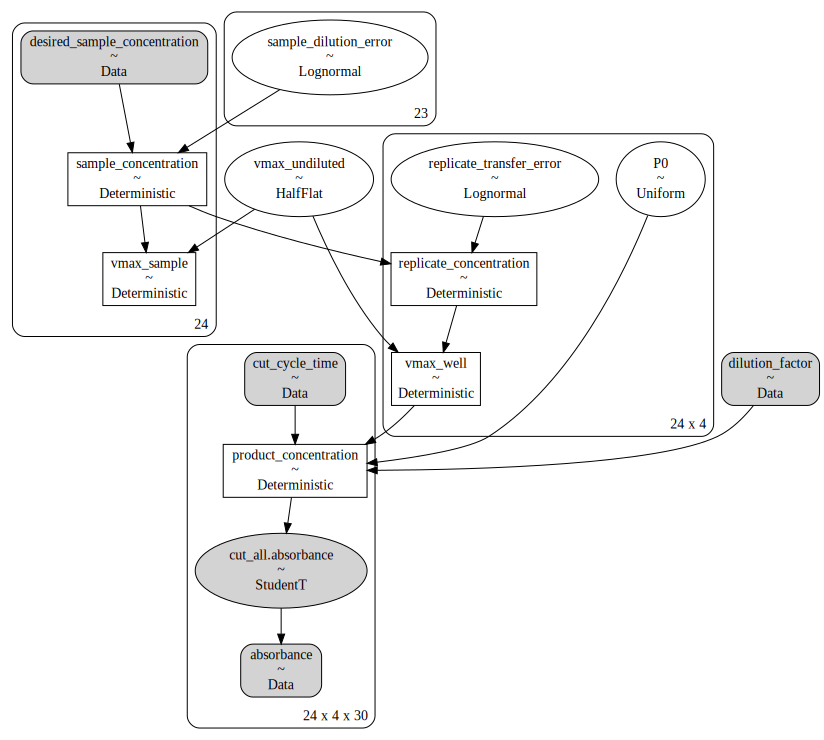

In [236]:
with pymc3.Model() as pmodel_cut:
    sample_concentration, replicate_concentration = helper.model_concentrations(df_cut_concentration, sd=0.3)
    helper.model_cutinase(t_obs, y_obs, em_nitrophenol)
    
print(f"{pmodel_cut.ndim} dimensions")
pymc3.model_to_graphviz(pmodel_cut)

In [237]:
with pmodel_cut:
    idata_cut = pymc3.sample(
        return_inferencedata=True,
        #target_accept=0.9, tune=2000, draws=2000,
    )

idata_cut.to_netcdf(pathlib.Path(DP_RESULTS, 'trace_cutinase.nc'))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [P0, vmax_undiluted, replicate_transfer_error, sample_dilution_error]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 82 seconds.


WindowsPath('9REA8P_Results/trace_cutinase.nc')

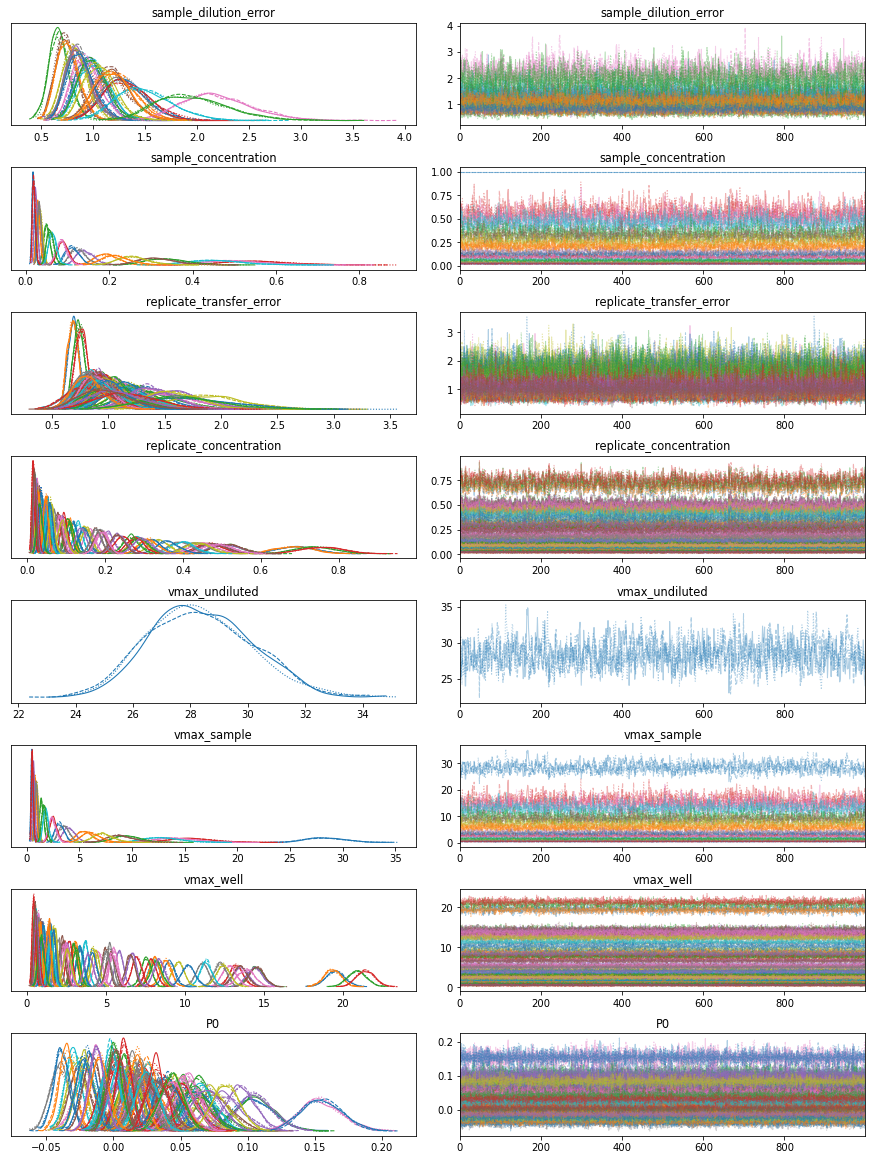

In [238]:
arviz.plot_trace(
    idata_cut, compact=True,
    var_names=[
        "sample_dilution_error",
        "sample_concentration",
        "replicate_transfer_error",
        "replicate_concentration",
        "vmax_undiluted",
        "vmax_sample",
        "vmax_well",
        "P0",
    ]
);

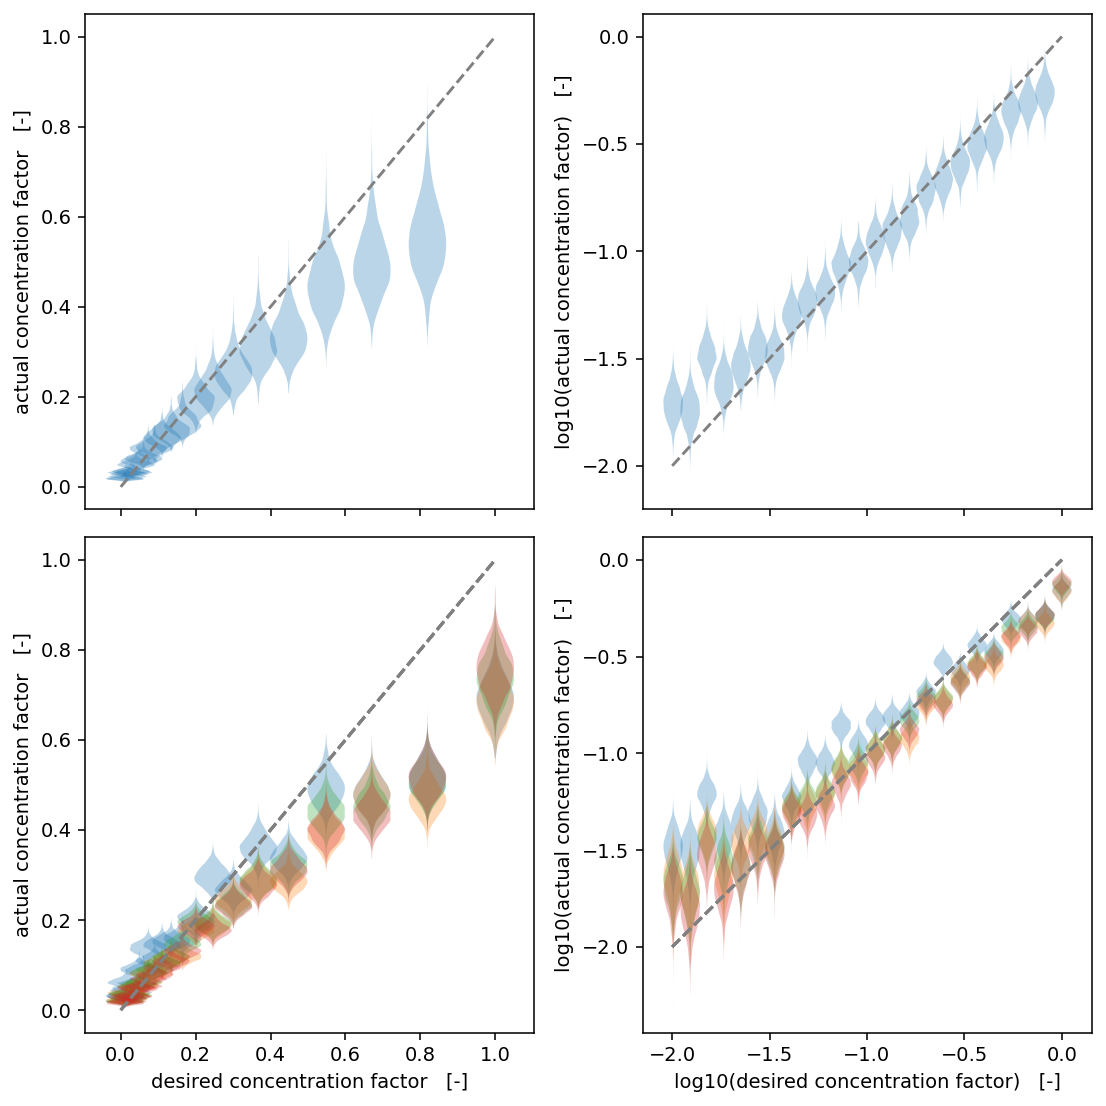

In [264]:
fig, axs = helper.plot_concentration_error(idata_cut)
pyplot.show()

In [265]:
def plot(sample_well:str):
    replicates = idata_cut.posterior.replicate.values
    fig, axs = pyplot.subplots(
        dpi=140,
        ncols=len(replicates), figsize=(4*len(replicates), 4), sharey="row"
    )
    
    for r, ax in zip(replicates, axs):
        x = idata_cut.constant_data.cut_cycle_time.sel(sample_well=sample_well, replicate=r).values
        pymc3.gp.util.plot_gp_dist(
            ax=ax,
            x=x,
            samples=idata_cut.posterior.product_concentration.stack(sample=('chain', 'draw')).sel(
                sample_well=sample_well, replicate=r
            ).T,
            samples_alpha=0,
        )
        ax.scatter(
            x,
            em_nitrophenol.predict_independent(
                idata_cut.constant_data.absorbance.sel(sample_well=sample_well, replicate=r).values
            ),
        )
        ax.set_xlabel('time   [min]')
    axs[0].set_ylabel('product concentration   [mmol/L]')
    pyplot.show()

ipywidgets.interact(
    plot,
    sample_well=idata_cut.posterior.sample_well.values
);

interactive(children=(Dropdown(description='sample_well', options=('A01', 'A02', 'A03', 'B01', 'B02', 'B03', '…

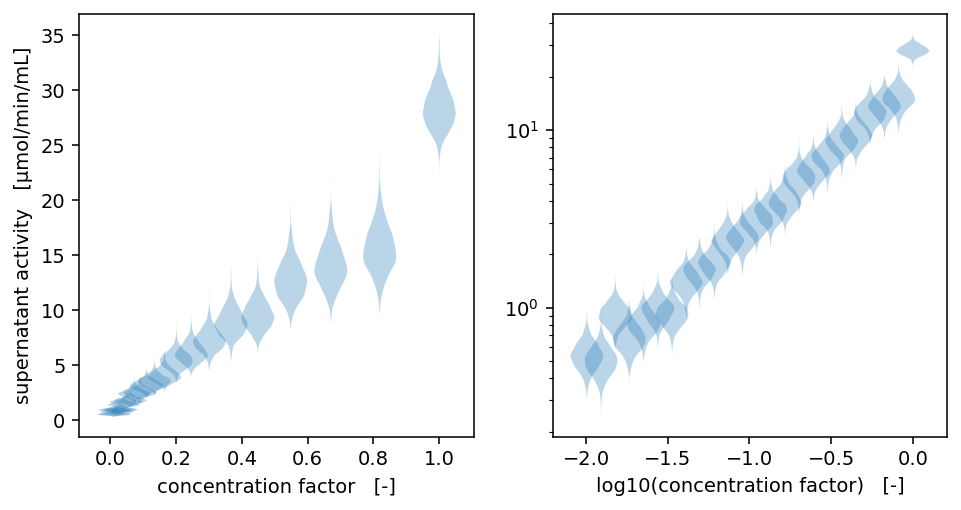

In [266]:
fig, (left, right) = pyplot.subplots(dpi=140, figsize=(8, 4), ncols=2)

samples = [
    idata_cut.posterior.vmax_sample.sel(sample_well=swell).values.flatten()
    for swell in idata_cut.posterior.sample_well
]
positions = df_cut_concentration["concentration_factor"]

left.violinplot(
    dataset=samples,
    positions=positions,
    widths=0.1,
    showextrema=False,
)
right.violinplot(
    dataset=samples,
    positions=numpy.log10(positions),
    widths=0.2,
    showextrema=False,
)

left.set_ylabel("supernatant activity   [µmol/min/mL]")
left.set_xlabel("concentration factor   [-]")
right.set_yscale("log")
right.set_xlabel("log10(concentration factor)   [-]")
pyplot.show()

### sGFP fluorescence limits (standalone)
1. read sGFP fluorescences into a single DataFrame
2. build mass action kinetics model

In [267]:
df_sGFP, t0_delta = helper.read_gfp(DP_RUN)

The MTP was pipetted at 2020-11-19 18:43:11+00:00 (0.958 hours before the end of the first measurement).
!! Overriding t0_delta with 0.25 hours !!


In [268]:
def plot_sGFP(sample_well: str):
    fig, ax = pyplot.subplots(dpi=140)

    for awell in df_cut_concentration.loc[sample_well, "assay_wells"].split(","):
        ax.scatter(
            df_sGFP.index,
            df_sGFP[awell],
            label=f"assay {awell}"
        )
    ax.legend(frameon=False)
    pyplot.show()

ipywidgets.interact(
    plot_sGFP,
    sample_well=numpy.array(df_cut_concentration.index).reshape(8, 3).flatten("F")
);

interactive(children=(Dropdown(description='sample_well', options=('A01', 'B01', 'C01', 'D01', 'E01', 'F01', '…

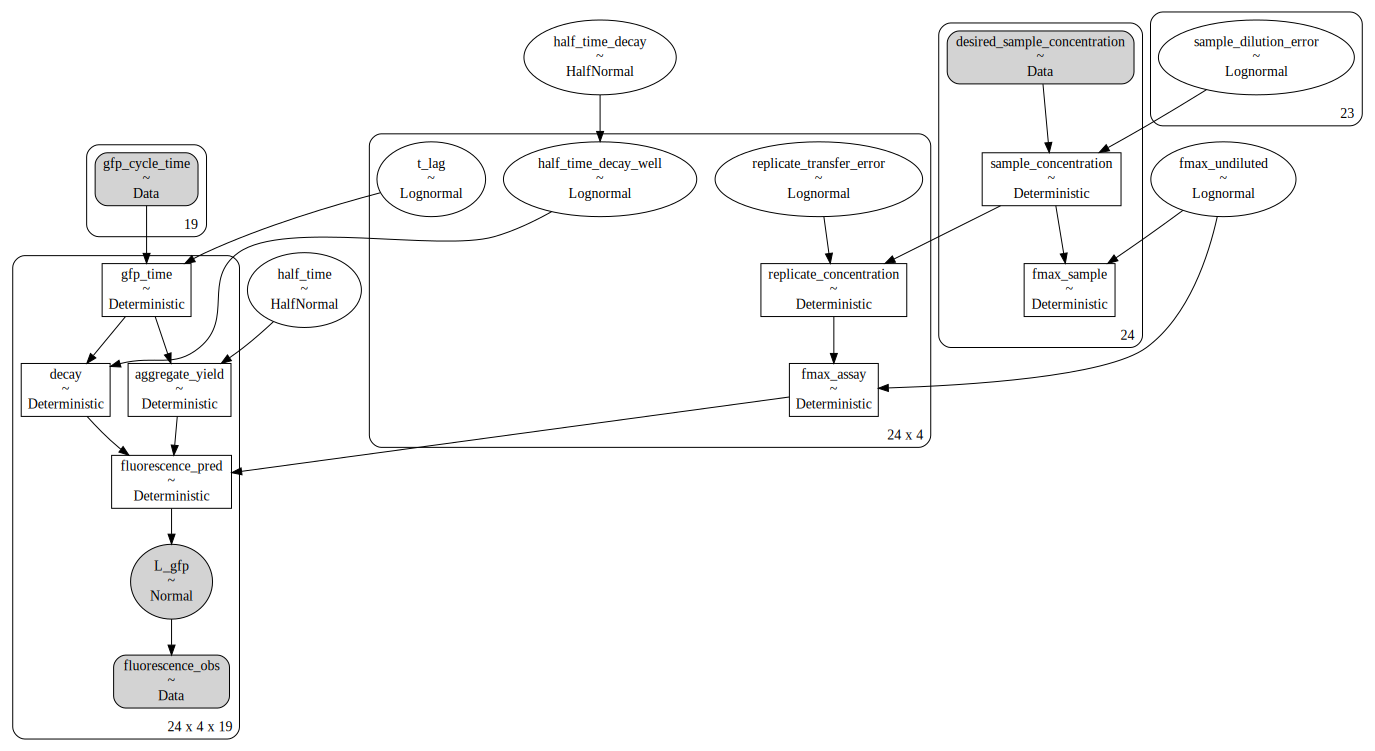

In [269]:
with pymc3.Model(coords=coords) as pmodel_gfp:
    sample_concentration, replicate_concentration = helper.model_concentrations(df_cut_concentration, sd=0.3)
    helper.model_gfp(df_cut_concentration, df_sGFP, t0_delta)
    
pymc3.model_to_graphviz(pmodel_gfp)

In [271]:
def plot_pp(varname):
    with pmodel_gfp:
        pp = pymc3.sample_prior_predictive(var_names=[varname])

    fig, ax = pyplot.subplots(dpi=140)
    pymc3.gp.util.plot_gp_dist(
        ax=ax,
        x=pmodel.coords["gfp_cycle"],
        samples=pp[varname][:, 0, 1],
        samples_alpha=0
    )
    if varname in "fluorescence_pred":
        ax.set_ylim(*numpy.percentile(pp[varname][:, 0, 1], [0, 95]))
    ax.set_title(f"prior predictive '{varname}'")
    pyplot.show()
ipywidgets.interact(
    plot_pp, varname=["gfp_time", "decay", "aggregate_yield", "fluorescence_pred"]
);

interactive(children=(Dropdown(description='varname', options=('gfp_time', 'decay', 'aggregate_yield', 'fluore…

In [272]:
with pmodel_gfp:
    idata_gfp = pymc3.sample(
        return_inferencedata=True,
        #tune=2000, draws=2000, target_accept=0.9,
    )
idata_gfp.to_netcdf(pathlib.Path(DP_RESULTS, "trace_gfp.nc"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [half_time_decay_well, half_time_decay, half_time, fmax_undiluted, t_lag, replicate_transfer_error, sample_dilution_error]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 244 seconds.
The number of effective samples is smaller than 25% for some parameters.


WindowsPath('9REA8P_Results/trace_gfp.nc')

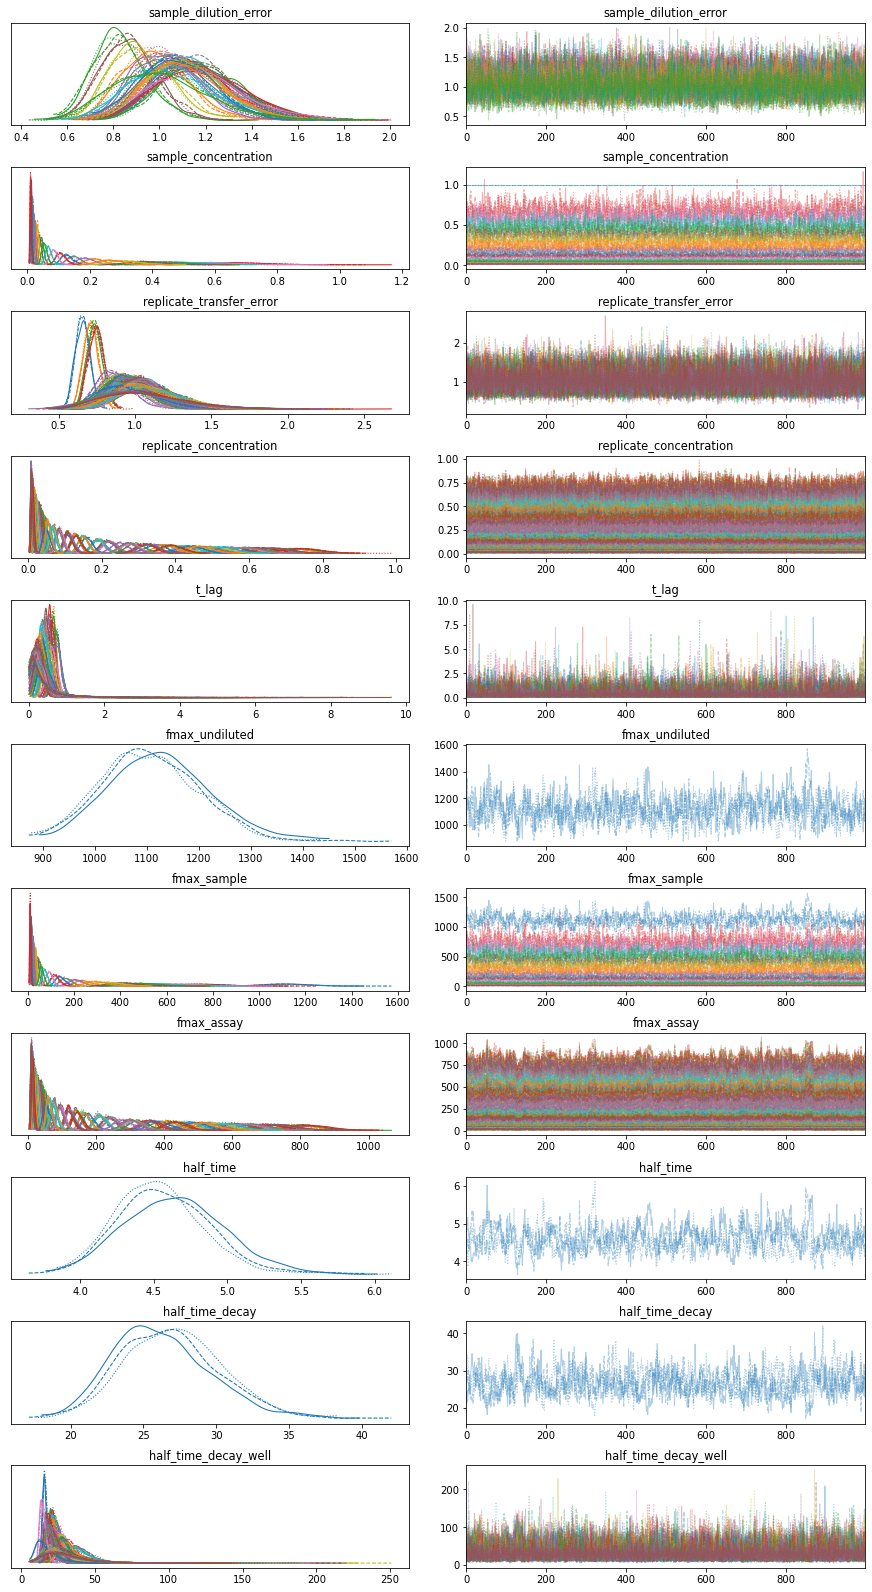

In [275]:
arviz.plot_trace(
    idata_gfp,
    var_names=[
        "sample_dilution_error",
        "sample_concentration",
        "replicate_transfer_error",
        "replicate_concentration",
        "t_lag",
        "fmax_undiluted",
        "fmax_sample",
        "fmax_assay",
        "half_time",
        "half_time_decay",
        "half_time_decay_well",
    ],
    compact=True
);

In [282]:
def plot_gfp_fit(sample_well: str):
    fig, axs = pyplot.subplots(dpi=140, ncols=4, nrows=2, figsize=(12, 6), sharey="row", sharex="col")

    for ax, replicate in zip(axs[0,:], idata_gfp.posterior.replicate.values):
        fmax_assay = idata_gfp.posterior.fmax_assay.stack(
            sample=("chain", "draw")
        ).sel(sample_well=sample_well, replicate=replicate)
        agg_yield = idata_gfp.posterior.aggregate_yield.stack(
            sample=("chain", "draw")
        ).sel(sample_well=sample_well, replicate=replicate)
        f_no_decay = fmax_assay * agg_yield

        
        # plot the limit
        x_min = min(idata_gfp.constant_data.gfp_cycle_time.values)
        x_max = max(idata_gfp.constant_data.gfp_cycle_time.values)
        x_center = (x_min + x_max) / 2
        # global limit:
        pymc3.gp.util.plot_gp_dist(
            ax=ax,
            samples=numpy.array([
                idata_gfp.posterior.fmax_sample.stack(
                    sample=("chain", "draw")
                ).sel(sample_well=sample_well)
            ]*2).T,
            x=numpy.array([x_min, x_center]),
            samples_alpha=0,
            palette="Greys",
        )
        # well-wise limit
        pymc3.gp.util.plot_gp_dist(
            ax=ax,
            samples=numpy.array([fmax_assay]*2).T,
            x=numpy.array([x_center, x_max]),
            samples_alpha=0,
            palette="Blues",
        )
        
        # and fluorescence if there was no decay
        pymc3.gp.util.plot_gp_dist(
            ax=ax,
            samples=f_no_decay.values,
            x=idata_gfp.constant_data.gfp_cycle_time.values,
            samples_alpha=0,
            palette="Greens",
        )
        
        # and the actual fluorescence
        pymc3.gp.util.plot_gp_dist(
            ax=ax,
            samples=idata_gfp.posterior.fluorescence_pred.stack(
                sample=("chain", "draw")
            ).sel(sample_well=sample_well, replicate=replicate).values.T,
            x=idata_gfp.constant_data.gfp_cycle_time.values,
            samples_alpha=0,
        )
        ax.scatter(
            idata_gfp.constant_data.gfp_cycle_time.values,
            idata_gfp.constant_data.fluorescence_obs.sel(sample_well=sample_well, replicate=replicate),
        )

    # residuals for the fluorescence
    for ax, replicate in zip(axs[1,:], idata_gfp.posterior.replicate.values):
        samples = idata_gfp.posterior.fluorescence_pred.stack(
            sample=("chain", "draw")
        ).sel(sample_well=sample_well, replicate=replicate)
        median = samples.median("sample").values.T
        pymc3.gp.util.plot_gp_dist(
            ax=ax,
            samples=(samples.values.T - median) / median * 100,
            x=idata_gfp.constant_data.gfp_cycle_time.values,
            samples_alpha=0,
        )
        data = idata_gfp.constant_data.fluorescence_obs.sel(sample_well=sample_well, replicate=replicate)
        rel_residuals = ((data - median) / median * 100).values
        ax.scatter(idata_gfp.constant_data.gfp_cycle_time.values, rel_residuals)
        ax.set_title(f"replicate {replicate}")
    axs[0, 0].set_ylim(0)
    axs[0, 0].set_ylabel(
        "fluorescence\n"
        "in sample well (grey)\n"
        "in assay well (blue)\n"
        "without decay (green)"
    )
    axs[1, 0].set_ylim(-numpy.ptp(rel_residuals), numpy.ptp(rel_residuals))
    axs[1, 0].set_ylabel("residual   [%]")
    fig.suptitle(f"Model fit to replicates from sample well {sample_well}\n")
    pyplot.show()

ipywidgets.interact(
    plot_gfp_fit,
    sample_well=idata_gfp.posterior.sample_well.values.reshape(8, 3).flatten("F")
);

interactive(children=(Dropdown(description='sample_well', options=('A01', 'B01', 'C01', 'D01', 'E01', 'F01', '…

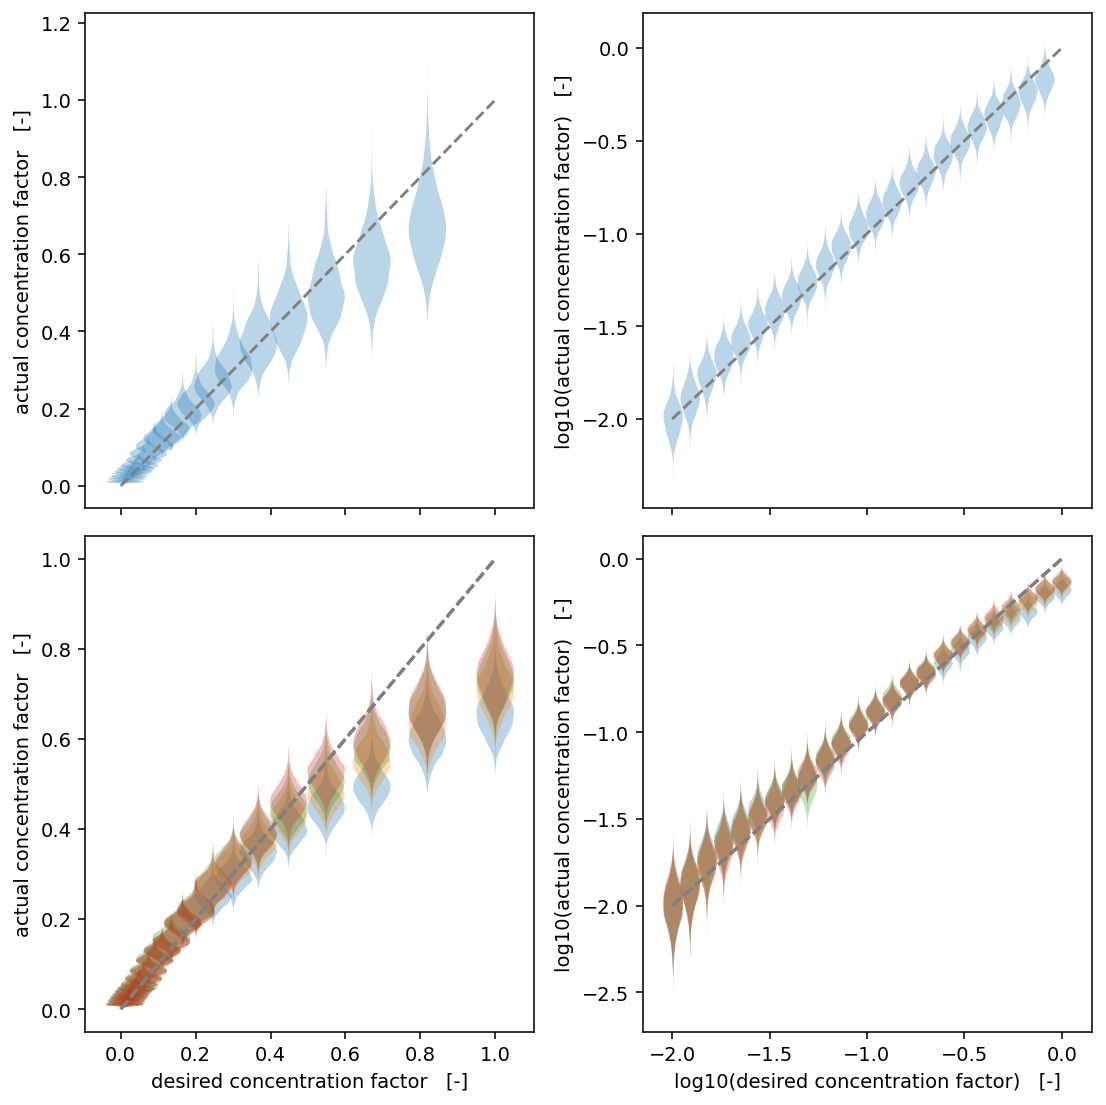

In [283]:
fig, axs = helper.plot_concentration_error(idata_gfp)
pyplot.show()

In [294]:
assay_well_96 = numpy.array([
    [f"{r}{c:02d}" for c in range(1, 13)]
    for r in "ABCDEFGH"
])
sample_well_96 = numpy.hstack([
    pmodel_gfp.coords["sample_well"].reshape(8, 3)
    for _ in range(4)
])
replicate_96 = numpy.repeat(
    pmodel_gfp.coords["replicate"],
    len(pmodel_gfp.coords["sample_well"])
).reshape(8, 12, order="F")
assay_well_to_swr = {
    awell : (swell, rep)
    for awell, swell, rep in zip(assay_well_96.flatten(), sample_well_96.flatten(), replicate_96.flatten())
}

def stack_to_96(samples):
    stacked = samples.stack(sample=("chain", "draw"))
    reshaped = numpy.array([
        stacked.sel(sample_well=swell, replicate=rep)
        for awell, (swell, rep) in assay_well_to_swr.items()
    ]).reshape(8, 12, stacked.sizes["sample"])
    return xarray.DataArray(reshaped, dims=("row", "column", "sample"))

In [295]:
def plot(varname):
    pyplot.imshow(numpy.median(
        stack_to_96(idata_gfp.posterior[varname]),
        axis=-1
    ))
    pyplot.title(varname)
    pyplot.colorbar();
ipywidgets.interact(plot, varname=[
    "t_lag", "half_time_decay_well",
    "replicate_transfer_error"
]);

interactive(children=(Dropdown(description='varname', options=('t_lag', 'half_time_decay_well', 'replicate_tra…

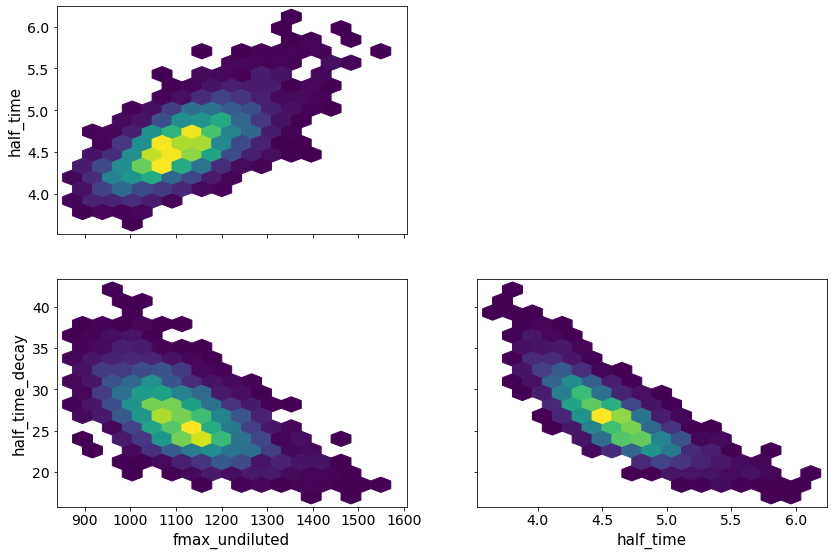

In [296]:
arviz.rcParams["plot.max_subplots"] = 100
arviz.plot_pair(
    idata_gfp,
    kind="hexbin", divergences=True,
    var_names=["fmax_undiluted", "half_time", "half_time_decay"],
);

### Joint Model

411 dimensions


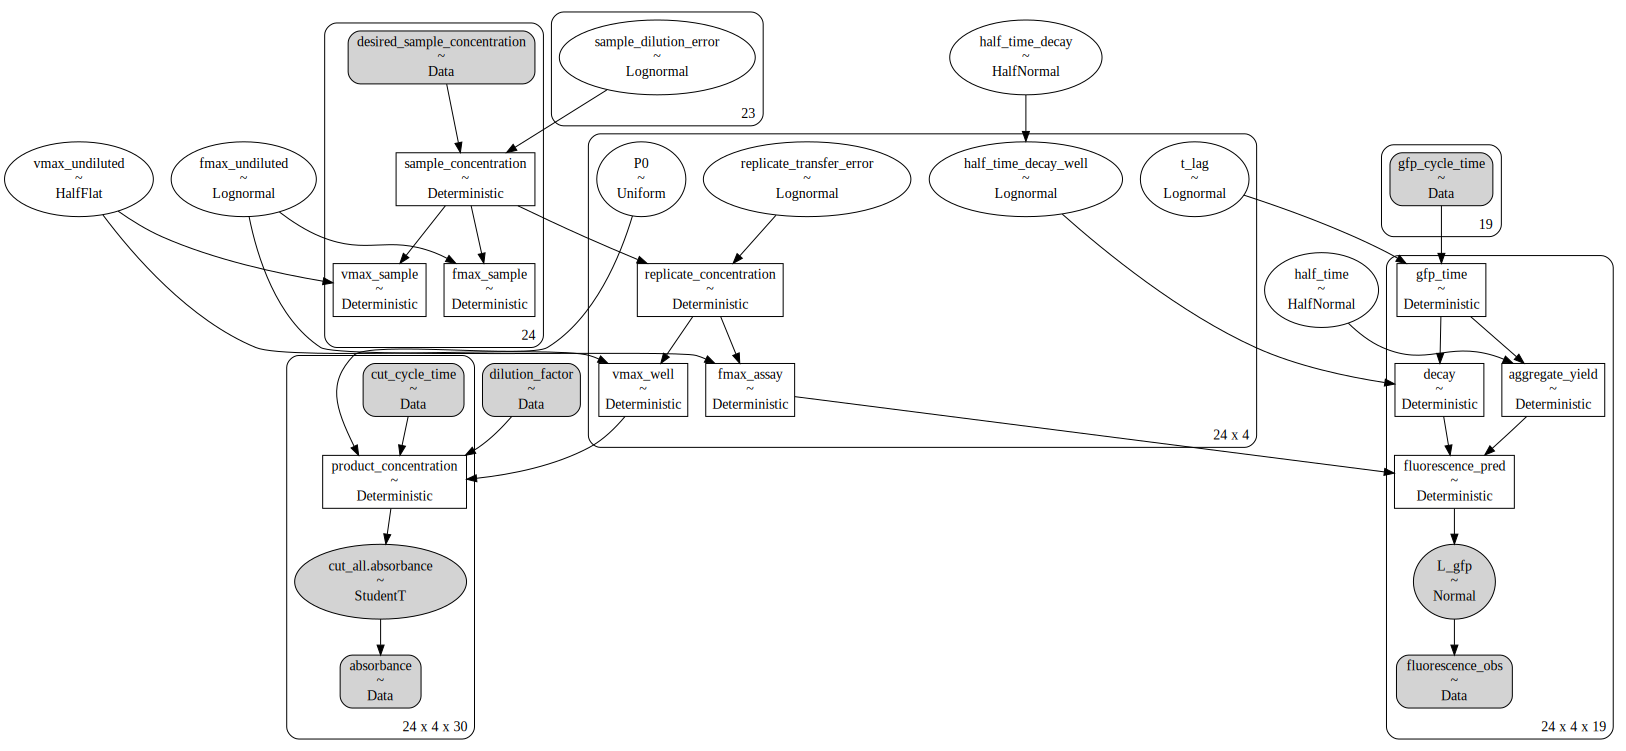

In [297]:
with pymc3.Model() as pmodel:
    sample_concentration, replicate_concentration = helper.model_concentrations(df_cut_concentration, sd=0.3)
    helper.model_cutinase(t_obs, y_obs, em_nitrophenol)
    helper.model_gfp(df_cut_concentration, df_sGFP, t0_delta)

print(f"{pmodel.ndim} dimensions")
pymc3.model_to_graphviz(pmodel)

In [313]:
with pmodel:
    idata = pymc3.sample(
        return_inferencedata=True,
        target_accept=0.9, tune=2000, draws=2000,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [half_time_decay_well, half_time_decay, half_time, fmax_undiluted, t_lag, P0, vmax_undiluted, replicate_transfer_error, sample_dilution_error]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 953 seconds.
The number of effective samples is smaller than 10% for some parameters.


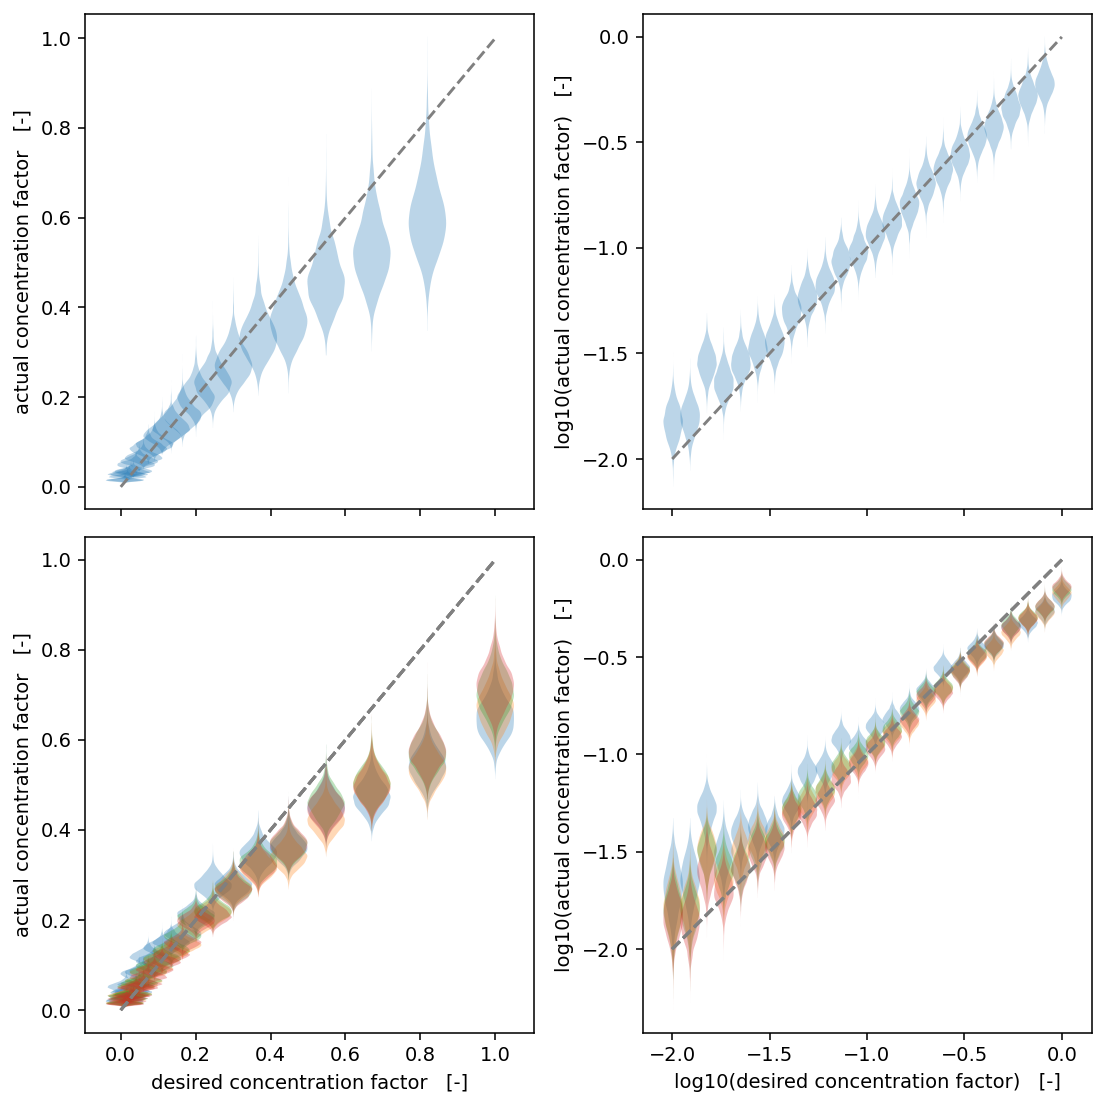

In [314]:
fig, axs = helper.plot_concentration_error(idata)
pyplot.show()

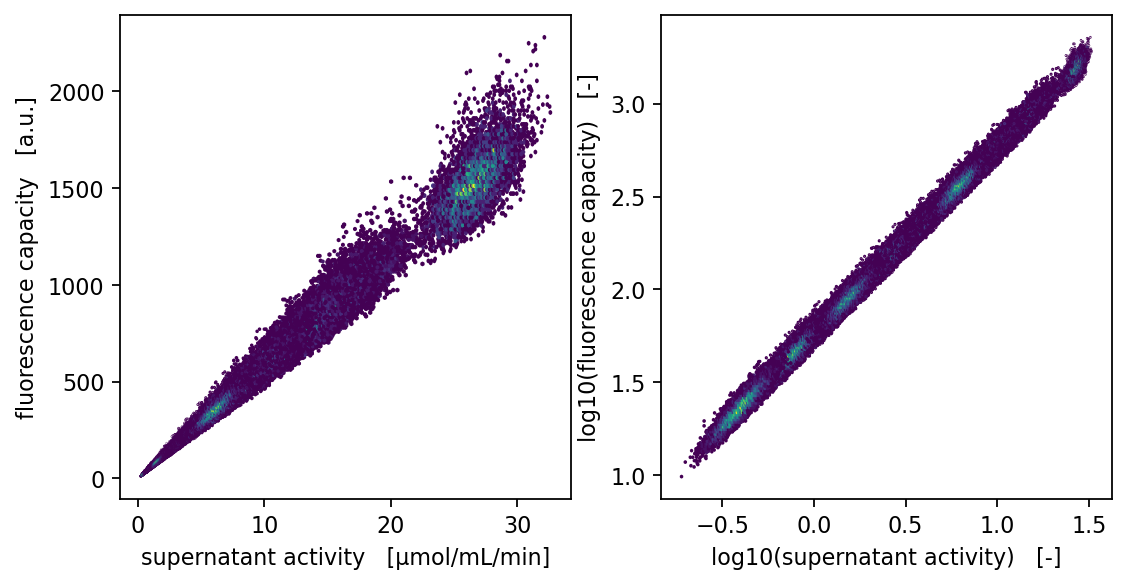

In [315]:
fig, (left, right) = pyplot.subplots(dpi=160, figsize=(8, 4), ncols=2)

samples_gfp = [
    idata.posterior.fmax_sample.sel(sample_well=swell).stack(sample=("chain", "draw"))
    for swell in idata.posterior.sample_well
]
samples_cut = [
    idata.posterior.vmax_sample.sel(sample_well=swell).stack(sample=("chain", "draw"))
    for swell in idata.posterior.sample_well
]
median_gfp = [
    float(s.median("sample"))
    for s in samples_gfp
]
median_cut = [
    float(s.median("sample"))
    for s in samples_cut
]

# fluorescence uncertainty
for i in range(len(samples_gfp)):
    left.hexbin(
        samples_cut[i], samples_gfp[i], mincnt=1
    )
    right.hexbin(
        numpy.log10(samples_cut[i]),
        numpy.log10(samples_gfp[i]),
        mincnt=1
    )

left.set_xlabel("supernatant activity   [µmol/mL/min]")
left.set_ylabel("fluorescence capacity   [a.u.]")
right.set_xlabel("log10(supernatant activity)   [-]")
right.set_ylabel("log10(fluorescence capacity)   [-]")
pyplot.show()

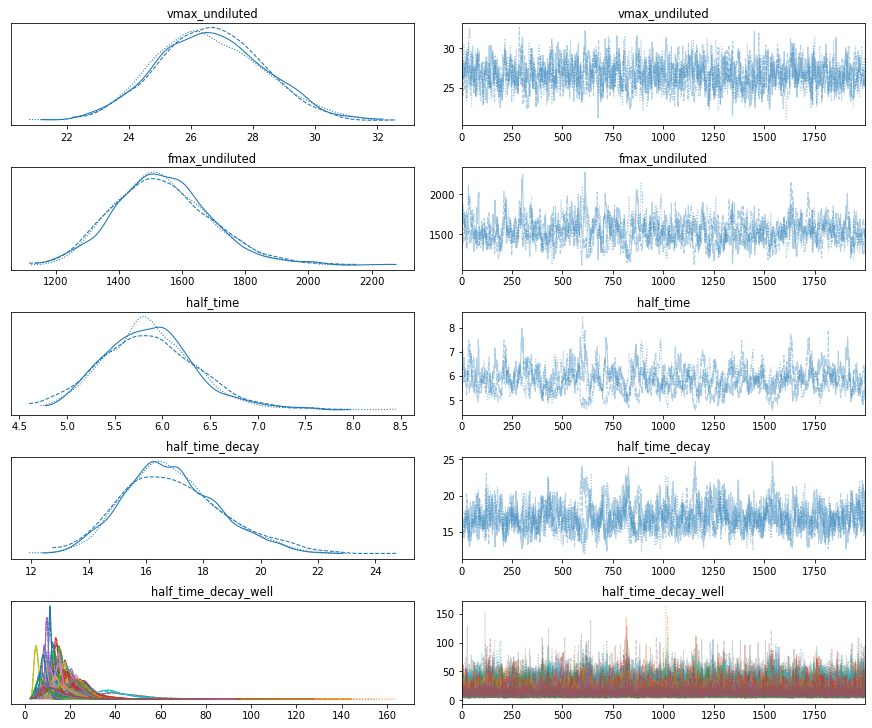

In [316]:
arviz.plot_trace(
    idata,
    var_names=[
        "vmax_undiluted",
        "fmax_undiluted", 
        "half_time", "half_time_decay",
        "half_time_decay_well",
    ],
    compact=True,
);

In [317]:
def plot(idata, varname):
    if not varname in idata.posterior:
        return
    pyplot.imshow(numpy.median(
        stack_to_96(idata.posterior[varname]),
        axis=-1
    ))
    pyplot.title(varname)
    pyplot.colorbar();
ipywidgets.interact(
    plot,
    idata=ipywidgets.Dropdown(description="model", options=[
        ("cutinase", idata_cut),
        ("gfp", idata_gfp),
        ("joint", idata),
    ]),
    varname=[
        "t_lag", "half_time_decay_well",
        "P0", "replicate_transfer_error"
    ]
);

interactive(children=(Dropdown(description='model', options=(('cutinase', Inference data with groups:
	> poste…

In [318]:
plan

Serial dilution plan (0.01011 to 1.00) from at least 5023.0 µL stock and 17777.0 µL diluent:
	Prepare column 1 with [950. 778. 637. 521. 426. 349. 286. 234.] µL from stock and fill up to 950 µL
	Prepare column 2 with [191. 157. 128. 105.  86.  70.  58.  47.] µL from stock and fill up to 950 µL
	Prepare column 3 with [39. 39. 39. 39. 39. 39. 39. 39.] µL from column 0 and fill up to 950 µL (1 serial dilutions)

In [319]:
df_cut_concentration

concentration_factor fp_well      assay_wells
sample_well                                               
A01                      1.000000    None  A01,A04,A07,A10
A02                      0.201053    None  A02,A05,A08,A11
A03                      0.041053    None  A03,A06,A09,A12
B01                      0.818947    None  B01,B04,B07,B10
B02                      0.165263    None  B02,B05,B08,B11
B03                      0.033620    None  B03,B06,B09,B12
C01                      0.670526    None  C01,C04,C07,C10
C02                      0.134737    None  C02,C05,C08,C11
C03                      0.027527    None  C03,C06,C09,C12
D01                      0.548421    None  D01,D04,D07,D10
D02                      0.110526    None  D02,D05,D08,D11
D03                      0.022514    None  D03,D06,D09,D12
E01                      0.448421    None  E01,E04,E07,E10
E02                      0.090526    None  E02,E05,E08,E11
E03                      0.018409    None  E03,E06,E09,E12
F01                      0.367368    None  F01,F04,F07,F10
F02                      0.073684    None  F02,F05,F08,F11
F03                      0.015081    None  F03,F06,F09,F12
G01                      0.301053    None  G01,G04,G07,G10
G02                      0.061053    None  G02,G05,G08,G11
G03                      0.012359    None  G03,G06,G09,G12
H01                      0.246316    None  H01,H04,H07,H10
H02                      0.049474    None  H02,H05,H08,H11
H03                      0.010112    None  H03,H06,H09,H12

In [647]:
def fun(x, half_time, fmax=fmax, ht_decay=False):
    tau = half_time / numpy.log(2)
    aggregate_yield = fmax * (1 - numpy.exp(-x / tau))
    if not ht_decay:
        return fmax * aggregate_yield
    else:
        tau_decay = ht_decay / numpy.log(2)
        decay_factor = (numpy.exp(-x / tau_decay))
        return fmax * aggregate_yield * decay_factor
    

def plot(ht1=3*0.5, ht2=3, ht_decay=10, decay=False):
    fig, ax = pyplot.subplots(dpi=140)
    
    if not decay:
        ht_decay = False

    for fmax in [0.25, 0.5, 1]:
        x1 = numpy.linspace(0, 1, 100)
        y1 = fun(x1, half_time=ht1, fmax=fmax, ht_decay=ht_decay)
        c = ax.plot(x1-1, y1)[0].get_color()

        x2 = numpy.linspace(0, 50, 1000)
        y2 = fun(x2, half_time=ht2, fmax=fmax, ht_decay=ht_decay)
        ifrom = numpy.argmax(y2>=y1[-1])
        delta_x = x2[ifrom]
        ax.plot(x2[ifrom:] - delta_x, y2[ifrom:], linestyle="-", color=c)
        ax.plot(x2[:ifrom] - delta_x, y2[:ifrom], linestyle=":", color=c)
        ax.axvline(-delta_x, linestyle='--')
    ax.axvline(0, linestyle='-', color="black")
    ax.set_xlim(right=15)
    ax.set_ylim(0, 1)

    pyplot.show()
    
ipywidgets.interact(
    plot,
    ht1=(1,10.0),
    ht2=(1,10.0),
    ht_decay=(1,30.0)
);

interactive(children=(FloatSlider(value=1.5, description='ht1', max=10.0, min=1.0), FloatSlider(value=3.0, des…